# Overview

The autoencoder developed is a proof of concept for keras on Azure notebooks withe MNIST dataset. The goal is to provide this code as it will help in general development of the GAN. 

At a later time we may return to the autoencoder to perhaps make the GAN find a solution faster / handle a local maxima.

In [6]:
# makes plots / images embedded in the file
%matplotlib inline

# Generate Autoencoder (Stage 1)

This wikipedia link should be helpful to understand the general idea
https://en.wikipedia.org/wiki/Autoencoder

In [7]:
# Import data

from keras.datasets import mnist
import numpy as np

(x1_train, y1_train), (x1_test, y1_test) = mnist.load_data()

inputShape = (28,28,1)
trainLength = 60000
testLength = 10000

# format data for consumption in the network
x1_train = x1_train.astype('float32') / 255
x1_test = x1_test.astype('float32') / 255
x1_train = np.reshape(x1_train, (len(x1_train), 28, 28, 1))
x1_test = np.reshape(x1_test, (len(x1_test), 28, 28, 1))


In [8]:
# Import keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D, Dense, Reshape, Flatten, Conv2DTranspose


In [9]:
# Generate an autoencoder layer
#
# [image] -> encoder -> [code] -> decoder -> [~image]
#
# The goal of an autoencoder layer is to generate the same output as was fed in. The catch is the network must learn to 
# compress the data. As noticed the first layer moves from an image to a set of smaller images as the code.

encoder1 = Sequential()
encoder1.add(Conv2D(8, (3,3), activation='relu', padding='same', input_shape=inputShape)) 
encoder1.add(SpatialDropout2D(0.25))
encoder1.add(Conv2D(8, (3,3), strides=(2,2), activation='relu', padding='same'))

codeShape1 = (14,14,8)

decoder1 = Sequential()
decoder1.add(Conv2DTranspose(4, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape1))
decoder1.add(Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same'))

print(encoder1.summary())
print(decoder1.summary())

inputImage1 = Input(shape=inputShape)
x = encoder1(inputImage1)
x = decoder1(x)
autoencoder1 = Model(inputImage1, x)
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         584       
Total params: 664
Trainable params: 664
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 4)         292       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 1)         37        
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________

In [10]:
# training network

history = autoencoder1.fit(x1_train, x1_train, epochs=4, batch_size=128, shuffle=True, validation_data=(x1_test,x1_test))

# 0.0661

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1716 - val_loss: 0.0675
Epoch 2/4
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0737 - val_loss: 0.0651
Epoch 3/4
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0705 - val_loss: 0.0642
Epoch 4/4
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0684 - val_loss: 0.0640


In [11]:
# Take a random test sample to demonstrate that it learned

import random
x = random.randint(0,testLength-1)
randImg = np.reshape(x1_test[x], (1, 28, 28, 1)) 

resultImg = autoencoder1.predict(randImg, batch_size=1)

In [12]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


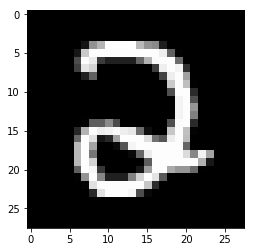

In [13]:
# Displaying original image

from matplotlib import pyplot as plt
origFig = plt.imshow(randImg, 'gray')

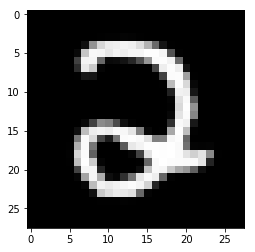

In [14]:
# Display the result after passing through the encoder

resFig = plt.imshow(resultImg, 'gray')

# Generate Autoencoder (Stage 2)

In [15]:
# Use encoder1 to generate the training and test-data for stage 2

x2_train = encoder1.predict(np.reshape(x1_train,(len(x1_train),28,28,1)))
x2_test = encoder1.predict(np.reshape(x1_test,(len(x1_test),28,28,1)))

print(x2_train.shape)
print(x2_test.shape)

(60000, 14, 14, 8)
(10000, 14, 14, 8)


In [16]:
print(codeShape1)

(14, 14, 8)


In [17]:
# this encoder has the goal of generating the same code as the from encoder 1.

encoder2 = Sequential()
encoder2.add(Conv2D(8, (3,3), activation='relu', padding='same', input_shape=codeShape1)) 
encoder2.add(SpatialDropout2D(0.25))
encoder2.add(Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same'))

codeShape2 = (7,7,16)

decoder2 = Sequential()
decoder2.add(Conv2DTranspose(8, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape2))

print(encoder2.summary())
print(decoder2.summary())

inputImage2 = Input(shape=codeShape1)
x = encoder2(inputImage2)
x = decoder2(x)
autoencoder2 = Model(inputImage2, x)
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 16)          1168      
Total params: 1,752
Trainable params: 1,752
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 8)         1160      
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# training network

history = autoencoder2.fit(x2_train, x2_train, epochs=4, batch_size=128, shuffle=True, validation_data=(x2_test,x2_test))

# 0.0661

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 67s 1ms/step - loss: -0.5163 - val_loss: -1.9774
Epoch 2/4
60000/60000 [==============================] - 54s 897us/step - loss: -1.8848 - val_loss: -2.2126
Epoch 3/4
60000/60000 [==============================] - 56s 937us/step - loss: -1.9946 - val_loss: -2.2840
Epoch 4/4
60000/60000 [==============================] - 53s 887us/step - loss: -2.1971 - val_loss: -2.4231


In [19]:
# stitch together encoders and decoders to prove valid training

x = random.randint(0,testLength-1)
randImg = np.reshape(x1_test[x], (1, 28, 28, 1)) 

resultImg = decoder1.predict(decoder2.predict(encoder2.predict(encoder1.predict(randImg))))

In [20]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


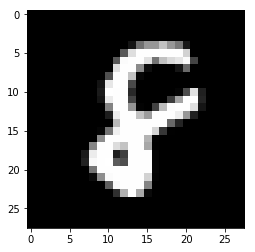

In [21]:
origFig = plt.imshow(randImg, 'gray')

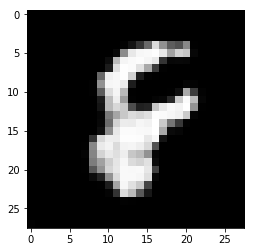

In [22]:
resFig = plt.imshow(resultImg, 'gray')

# tune auto-encoder 2

In [23]:
# Merging both autoencoder layers in order to better optimize the network

inputImageFull = Input(shape=inputShape)
x = encoder1(inputImageFull)
x = encoder2(x)
x = decoder2(x)
x = decoder1(x)
autoencoderfull = Model(inputImageFull, x)
autoencoderfull.compile(optimizer='adam', loss='binary_crossentropy')

In [24]:
# training network

history = autoencoderfull.fit(x1_train, x1_train, epochs=4, batch_size=128, shuffle=True, validation_data=(x1_test,x1_test))

# 0.0661

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 119s 2ms/step - loss: 0.0885 - val_loss: 0.0699
Epoch 2/4
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0743 - val_loss: 0.0679
Epoch 3/4
60000/60000 [==============================] - 122s 2ms/step - loss: 0.0713 - val_loss: 0.0674
Epoch 4/4
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0698 - val_loss: 0.0673


In [25]:
# stitch together encoders and decoders to prove valid training

x = random.randint(0,testLength-1)
randImg = np.reshape(x1_test[x], (1, 28, 28, 1)) 

resultImg = autoencoderfull.predict(randImg)

In [26]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


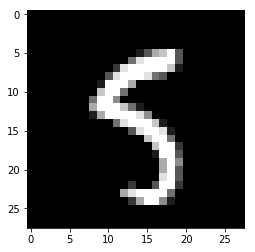

In [27]:
origFig = plt.imshow(randImg, 'gray')

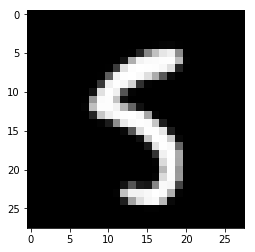

In [28]:
resFig = plt.imshow(resultImg, 'gray')

# Generate Stage 3

In [29]:
# Use encoder1 and encoder 2 to generate the training and test-data for stage 2

x3_train = encoder2.predict(encoder1.predict(np.reshape(x1_train,(len(x1_train),28,28,1))))
x3_test = encoder2.predict(encoder1.predict(np.reshape(x1_test,(len(x1_test),28,28,1))))

print(x3_train.shape)
print(x3_test.shape)

(60000, 7, 7, 16)
(10000, 7, 7, 16)


In [30]:
print(codeShape2)

(7, 7, 16)


In [44]:
# Generating a different kind of network now. Before we used convolution as that is relativly good for images, however our
# code is starting to get smaller so we are going to switch over to a flat network no

encoder3 = Sequential()
encoder3.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=codeShape2)) 
encoder3.add(SpatialDropout2D(0.25))
encoder3.add(Conv2D(16, (3,3), strides=(3,3), activation='relu', padding='same'))
encoder3.add(Flatten())
encoder3.add(Dense(64, activation='relu'))

codeShape3 = (64,)

decoder3 = Sequential()
decoder3.add(Dense(144, activation='relu', input_shape=codeShape3))
decoder3.add(Dense(784, activation='relu'))
decoder3.add(Reshape(codeShape2))

print(encoder3.summary())
print(decoder3.summary())

inputImage3 = Input(shape=codeShape2)
x = encoder3(inputImage3)
x = decoder3(x)
autoencoder3 = Model(inputImage3, x)
autoencoder3.compile(optimizer='adam', loss='mean_squared_error')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
spatial_dropout2d_16 (Spatia (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 3, 16)          2320      
_________________________________________________________________
flatten_10 (Flatten)         (None, 144)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                9280      
Total params: 13,920
Trainable params: 13,920
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

In [45]:
# training network

history = autoencoder3.fit(x3_train, x3_train, epochs=3, batch_size=512, shuffle=True, validation_data=(x3_test,x3_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 20s 325us/step - loss: 1.0578 - val_loss: 0.8947
Epoch 2/3
60000/60000 [==============================] - 19s 324us/step - loss: 0.5990 - val_loss: 0.7671
Epoch 3/3
60000/60000 [==============================] - 19s 310us/step - loss: 0.4910 - val_loss: 0.6690


In [46]:
# stitch together encoders and decoders to prove valid training

x = random.randint(0,testLength-1)
randImg = np.reshape(x1_test[x], (1, 28, 28, 1)) 

x = encoder1.predict(randImg)
x = encoder2.predict(x)
x = encoder3.predict(x)
x = decoder3.predict(x)
x = decoder2.predict(x)
resultImg = decoder1.predict(x)

In [47]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


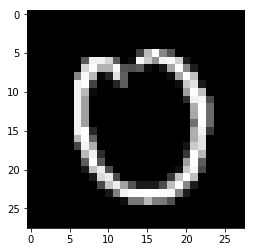

In [48]:
origFig = plt.imshow(randImg, 'gray')

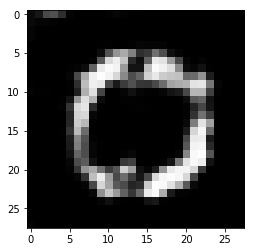

In [49]:
resFig = plt.imshow(resultImg, 'gray')

In [ ]:
# If we were to continue we would further tune encoder 3, then start encoder 4, tune encoder 4, etc.